In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit
import os

c:\Users\benjo\anaconda3\envs\lipreadGPU\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [15]:
# example mean reversion strategy taking the mean of the last day

# move up a directory
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)
print("Working directory:", os.getcwd())

# load tapes data
from tools import get_Tapes
raw_tapes = get_Tapes(3,0)

# move down a directory
os.chdir(current_directory)

Working directory: c:\Users\benjo\OneDrive\Data Science Masters\DSMP\dsmp-2024-group-19
Opening UoB_Set01_2025-01-02tapes.csv
Opening UoB_Set01_2025-01-03tapes.csv
Opening UoB_Set01_2025-01-06tapes.csv


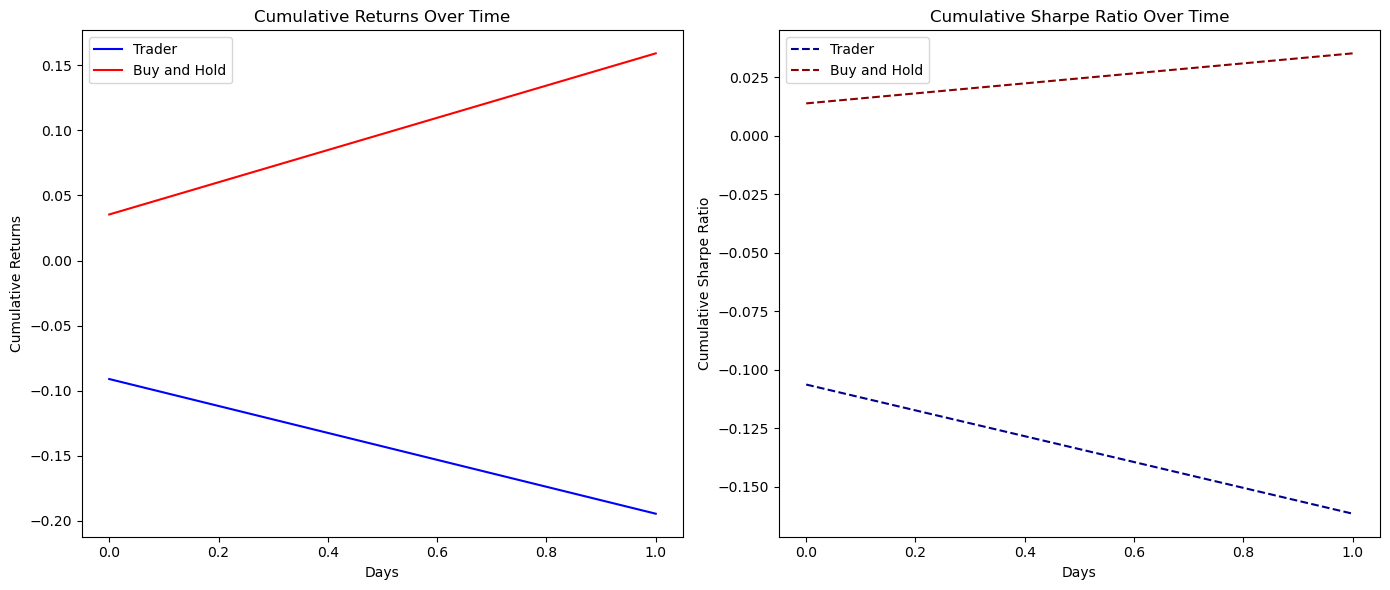

In [16]:
def display_performance(results):

    # Assuming results is a list containing trader_performance, buy_and_hold_performance, sharpe_trader, and sharpe_buy_and_hold
    trader_performance = np.array(results[0])
    buy_and_hold_performance = np.array(results[1])
    sharpe_trader = results[2]
    sharpe_buy_and_hold = results[3]

    # Calculate cumulative returns
    trader_cumulative_returns = np.cumsum(trader_performance)
    buy_and_hold_cumulative_returns = np.cumsum(buy_and_hold_performance)

    # Create time axis
    x = np.arange(len(trader_performance))

    # Create cumulative Sharpe ratios
    cumulative_sharpe_trader = np.cumsum(sharpe_trader)
    cumulative_sharpe_buy_and_hold = np.cumsum(sharpe_buy_and_hold)

    # Create figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot cumulative returns on the first subplot
    axs[0].plot(x, trader_cumulative_returns, label='Trader', color='blue')
    axs[0].plot(x, buy_and_hold_cumulative_returns, label='Buy and Hold', color='red')
    axs[0].set_ylabel('Cumulative Returns')
    axs[0].set_xlabel('Days')
    axs[0].set_title('Cumulative Returns Over Time')
    axs[0].legend()

    # Plot cumulative Sharpe ratios on the second subplot
    axs[1].plot(x, cumulative_sharpe_trader, label='Trader', color='darkblue', linestyle='--')
    axs[1].plot(x, cumulative_sharpe_buy_and_hold, label='Buy and Hold', color='darkred', linestyle='--')
    axs[1].set_ylabel('Cumulative Sharpe Ratio')
    axs[1].set_xlabel('Days')
    axs[1].set_title('Cumulative Sharpe Ratio Over Time')
    axs[1].legend()

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

def agg_tapes(raw_tapes, agg_level):
    agg_list = []
    for tape in raw_tapes:
        # Remove duplicate indices and resample to the specified aggregation level
        last_agg = tape[~tape.index.duplicated()].resample(agg_level).last()
        # Forward-fill missing values within each resampled segment
        agg_list.append(last_agg.ffill())
    return agg_list

import math
    
class Mean_Rev():
    def __init__(self, training_data, test_data):
        self.mean = (training_data["Price"] * training_data["Volume"]).sum() / training_data["Volume"].sum()
        test_prices = test_data["Price"].to_numpy()

        n = len(test_data)
        self.indicators = np.zeros(n)
        for i in range(n - 1):
            self.indicators[i] = (test_prices[i] < self.mean) * 2 - 1

    def action(self, index):
        return self.indicators[index]
    
class Mean_MA_trained():
    def __init__(self, training_data, test_data):
        test_prices = test_data["Price"].to_numpy()
        training_prices = training_data["Price"].to_numpy()
        # optimise window parameter
        max_window_value = math.log(len(training_prices), 1.6) // 1
        window_values = (1.6 ** (np.arange(max_window_value)[1:])).astype(int)
        
        scores = []
        for w in window_values:
            w_series = training_data["Price"].rolling(w).mean().to_numpy()
            scores.append(abs(0.5 - np.mean(w_series[w:] > training_prices[w:])))

        optimal_w = window_values[np.argmin(scores)]
        # build indicator

        n = len(test_data)
        self.indicators = np.zeros(n)
        window = optimal_w
        MA_series = test_data["Price"].rolling(window).mean().to_numpy()
        for i in range(n - window):
            MA = MA_series[i+window - 1]
            self.indicators[i+window - 1] = (test_prices[i+window - 1] < MA) * 2 - 1

    def action(self, index):
        return self.indicators[index]
    
class Mean_MA_10():
    def __init__(self, training_data, test_data):
        test_prices = test_data["Price"].to_numpy()


        optimal_w = 10
        # build indicator

        n = len(test_data)
        self.indicators = np.zeros(n)
        window = optimal_w
        MA_series = test_data["Price"].rolling(window).mean().to_numpy()
        for i in range(n - window):
            MA = MA_series[i+window - 1]
            self.indicators[i+window - 1] = (test_prices[i+window - 1] < MA) * 2 - 1

    def action(self, index):
        return self.indicators[index]
    
class Optimistic():
    def __init__(self, training_data, test_data):

        price_arr = test_data["Price"].to_numpy()
        n = len(test_data)
        self.indicators = np.zeros(n)
        lag = 1
        for i in range(n - lag):
            if price_arr[i+lag] > price_arr[i]:
                self.indicators[i+lag] = 1
            else:
                self.indicators[i+lag] = -1

    def action(self, index):
        return self.indicators[index]
    
class Rev_Optimistic():
    def __init__(self, training_data, test_data):

        price_arr = test_data["Price"].to_numpy()
        n = len(test_data)
        self.indicators = np.zeros(n)
        lag = 1
        for i in range(n - lag):
            if price_arr[i+lag] < price_arr[i]:
                self.indicators[i+lag] = 1
            else:
                self.indicators[i+lag] = -1

    def action(self, index):
        return self.indicators[index]

def test_strategy(agent, raw_tapes: list[pd.DataFrame], agg_level = "1min", starting_cash = 10_000):
    bias_val = 0

    tapes = agg_tapes(raw_tapes, agg_level)
    N = len(tapes)

    buy_and_hold_profits = []
    agent_profits = []
    agent_sharpe = []
    buy_and_hold_sharpe = []
    agent_daily_values = []
    for day_i in range(N-1):

        print(f"Day {day_i}", end = "\r")
        prev_day = tapes[day_i]
        curr_day = tapes[day_i + 1]

        Agent = agent(prev_day, curr_day)

        
        cash = starting_cash
        assets = 0
        c = 0
        agent_value = []
        for i, row in curr_day.iterrows():
            action = Agent.action(c)

            
            price = row["Price"]

            if price > 0 and price < 801:

                if action == 1:
                    if cash > price:
                        cash -= price + bias_val
                        assets += 1

                elif action == -1:
                    if assets > 0:
                        assets -= 1
                        cash += price - bias_val
                else:
                    pass

            agent_value.append(cash + assets * price)
            c += 1

        agent_return = (agent_value[-1] - starting_cash) / starting_cash
        agent_profits.append(agent_return)
        day_return = (curr_day.iloc[-1]["Price"] / curr_day.iloc[0]["Price"]) - 1
        buy_and_hold_profits.append(day_return)
        agent_daily_values.append(agent_value)


        RF_rate = 0
        if agent_return == 0:
            agent_sharpe.append(0)
        else:
            agent_value = np.array(agent_value)
            ex_returns = (np.diff(agent_value) / agent_value[:-1]) - RF_rate
            agent_sharpe.append(np.mean(ex_returns) / np.std(ex_returns))

        ex_returns = curr_day["Price"].pct_change() - RF_rate
        buy_and_hold_sharpe.append(np.mean(ex_returns) / np.std(ex_returns))

    return agent_profits, buy_and_hold_profits, agent_sharpe, buy_and_hold_sharpe, agent_daily_values

results = test_strategy(Optimistic, raw_tapes)
display_performance(results)

198/198 [==============================] - 12s 38ms/step - loss: 0.1783 - accuracy: 0.0000e+00
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 60, 60)            14880     
                                                                 
 lstm_39 (LSTM)              (None, 60)                29040     
                                                                 
 dense_38 (Dense)            (None, 30)                1830      
                                                                 
 dense_39 (Dense)            (None, 1)                 31        
                                                                 
Total params: 45,781
Trainable params: 45,781
Non-trainable params: 0
_________________________________________________________________
62/62 [==============================] - 2s 23ms/step
[[291.74155]
 [291.904  ]
 [291.

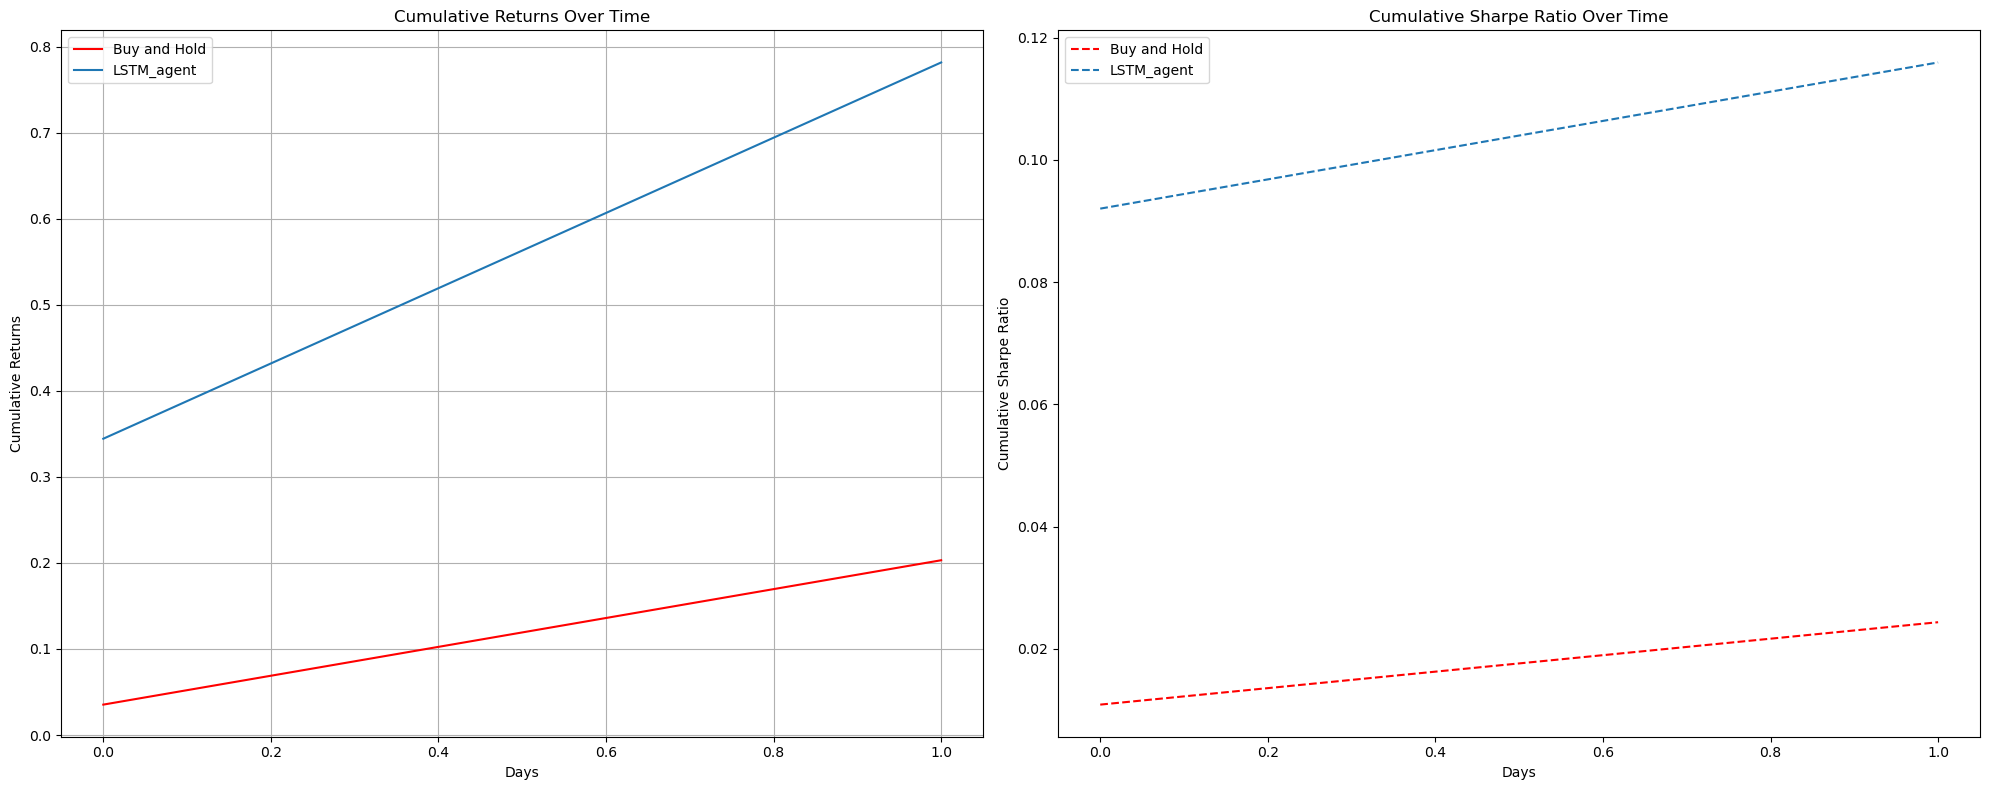

In [20]:

class ARMIA_agent():
    def __init__(self, training_data, test_data):
        n = len(test_data)
        self.indicators = np.zeros(n)
        test_prices = test_data["Price"].to_numpy()

        model = ARIMA(training_data["Price"], order=(1,0,1))
        result = model.fit()
        result2 = result.apply(test_data["Price"], refit=False)
        pred2 = np.array(result2.predict(start=0, end=n-1))

        for i in range(n - 1):
            if pred2[i] > test_prices[i]: # use one step behind as there is no inital prediction
                self.indicators[i] = 1
            else:
                self.indicators[i] =  -1

    def action(self, index):
        return self.indicators[index]
    
class LSTM_agent():
    def __init__(self, training_data, test_data):
        n = len(test_data)
        self.indicators = np.zeros(n)
        test_prices = test_data["Price"].to_numpy()

        from sklearn.preprocessing import StandardScaler 
        scaler = StandardScaler()

        scaled_train = scaler.fit_transform(training_data["Price"].values.reshape(-1,1))
        scaled_test = scaler.transform(test_data["Price"].values.reshape(-1,1))

        window = 60
        X_train = []
        y_train = []
        for i in range(window, len(scaled_train)):
            X_train.append(scaled_train[i-window:i, 0])
            y_train.append(scaled_train[i, 0])

        X_test = []
        y_test = []
        for i in range(window, len(scaled_test)):
            X_test.append(scaled_test[i-window:i, 0])
            y_test.append(scaled_test[i, 0])

        # The data is converted to Numpy array
        X_train, y_train = np.array(X_train), np.array(y_train)
        
        #Reshaping
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
        y_train = np.reshape(y_train, (y_train.shape[0],1))
        #print("X_train :",X_train.shape,"y_train :",y_train.shape)

        # The data is converted to numpy array
        X_test, y_test = np.array(X_test), np.array(y_test)
        
        #Reshaping
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
        y_test = np.reshape(y_test, (y_test.shape[0],1))
        #print("X_test :",X_test.shape,"y_test :",y_test.shape)

        # importing libraries
        from keras.models import Sequential
        from keras.layers import LSTM
        from keras.layers import Dense
        from sklearn import metrics

                #Initialising the model
        regressorLSTM = Sequential()
        
        #Adding LSTM layers
        regressorLSTM.add(LSTM(window, 
                            return_sequences = True, 
                            input_shape = (X_train.shape[1],1)))
        regressorLSTM.add(LSTM(window, 
                            return_sequences = False))
        regressorLSTM.add(Dense(window/2))
        
        #Adding the output layer
        regressorLSTM.add(Dense(1))
        
        #Compiling the model
        regressorLSTM.compile(optimizer = 'adam',
                            loss = 'mean_squared_error',
                            metrics = ["accuracy"])
        
        #Fitting the model
        regressorLSTM.fit(X_train, 
                        y_train, 
                        batch_size = 10, 
                        epochs = 1)
        regressorLSTM.summary()

        y_LSTM = regressorLSTM.predict(X_test)
        y_LSTM_O = scaler.inverse_transform(y_LSTM)
        print(y_LSTM_O)

        pred2 = np.array(y_LSTM_O)
        print(pred2)

        print(len(pred2), len(test_prices))
        

        for i in range(window,len(pred2)):
            if pred2[i] > test_prices[i]: # use one step behind as there is no inital prediction
                self.indicators[i] = 1
            else:
                self.indicators[i] =  -1

        print(self.indicators[window:])

    def action(self, index):
        return self.indicators[index]
    
class Cheater_agent():
    def __init__(self, training_data, test_data):
        n = len(test_data)
        self.indicators = np.zeros(n)
        test_prices = test_data["Price"].to_numpy()

        for i in range(n - 1):
            if test_prices[i+1] > test_prices[i]:
                self.indicators[i] = 1 
            else:
                self.indicators[i] =  -1

    def action(self, index):
        return self.indicators[index]
    
def compare_agents(agents: list, raw_tapes):
    num_agents = len(agents)
    all_results = []
    for agent in agents:
        all_results.append(test_strategy(agent, raw_tapes, "15s", 10_000))

    # Assuming results is a list containing trader_performance, buy_and_hold_performance, sharpe_trader, and sharpe_buy_and_hold
    buy_and_hold_performance = all_results[0][1]
    sharpe_buy_and_hold = all_results[0][3]

    # Calculate cumulative returns
    buy_and_hold_cumulative_returns = np.cumsum(buy_and_hold_performance)

    # Create time axis
    x = np.arange(len(buy_and_hold_performance))

    # Create cumulative Sharpe ratios
    cumulative_sharpe_buy_and_hold = np.cumsum(sharpe_buy_and_hold)

    # Create figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    # Plot cumulative returns on the first subplot
    axs[0].plot(x, buy_and_hold_cumulative_returns, label='Buy and Hold', color='red')

    for i in range(num_agents):
        trader_performance = all_results[i][0]
        trader_cumulative_returns = np.cumsum(trader_performance)
        axs[0].plot(x, trader_cumulative_returns, label=agents[i].__name__)

    axs[0].set_ylabel('Cumulative Returns')
    axs[0].set_xlabel('Days')
    axs[0].set_title('Cumulative Returns Over Time')
    axs[0].legend()
    axs[0].grid(True)

    # Plot cumulative Sharpe ratios on the second subplot
    axs[1].plot(x, cumulative_sharpe_buy_and_hold, label='Buy and Hold', color='red', linestyle='--')

    for i in range(num_agents):
        sharpe_trader = all_results[i][2]
        trader_cumulative_returns = np.cumsum(trader_performance)
        cumulative_sharpe_trader = np.cumsum(sharpe_trader)
        axs[1].plot(x, cumulative_sharpe_trader, label=agents[i].__name__, linestyle='--')

    axs[1].set_ylabel('Cumulative Sharpe Ratio')
    axs[1].set_xlabel('Days')
    axs[1].set_title('Cumulative Sharpe Ratio Over Time')
    axs[1].legend()

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

compare_agents([LSTM_agent], raw_tapes)